In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
%matplotlib inline

In [2]:
np.__version__

'1.19.5'

### 1. Get data using API

#### Step 1: Send request

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
crypto = 'BTC'
limit = 2000
res = requests.get(endpoint + '?fsym=' + crypto + '&tsym=USD&limit=' + str(limit))

#### Step 2: Load data to the dataframe

In [2]:
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist['time'] = pd.to_datetime(hist['time'], unit='s').dt.strftime('%Y-%m-%d')
hist = hist.drop(['conversionSymbol', 'conversionType'], axis=1)
hist['crypto'] = crypto

target_col = 'close'
hist.head()

In [37]:
# hist.head()

,time,close,high,low,open,volumefrom,volumeto,crypto
0,2015-10-01,237.05,238.66,234.70,235.93,52884.47,12534482.83,BTC
1,2015-10-02,236.71,238.45,235.14,237.05,47941.60,11378441.69,BTC
2,2015-10-03,238.58,239.52,236.07,236.71,43304.67,10338780.01,BTC
3,2015-10-04,238.33,277.58,237.51,238.58,31854.49,7618430.27,BTC
4,2015-10-05,240.15,240.53,236.41,238.33,61240.52,14631928.87,BTC


In [3]:
# hist = pd.read_csv('crypto_info_df')

In [4]:
target_col = 'close'

### 2. Connect to the PostgreSQL & Create a Database

#### Step 1: Import the libraries

In [39]:
# import sys to get more detailed Python exception info
import sys

# import the connect library for psycopg2
import psycopg2

# import the error handling libraries for psycopg2
from psycopg2 import OperationalError, errorcodes, errors

import psycopg2.extras as extras


#### Step 2: Specify the connection parameters

In [40]:
# Note: please change your database, username & password as per your own values

conn_params_dic = {
    "host"      : "localhost",
    "user"      : "postgres",
    "password"  : "1103"
}

#### Step 3: Define a function that handles and parses psycopg2 exceptions

In [41]:
def show_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()

    # get the line number when exception occured
    line_n = traceback.tb_lineno

    # print the connect() error
    print ("\npsycopg2 ERROR:", err, "on line number:", line_n)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type)

    # psycopg2 extensions.Diagnostics object attribute
    print ("\nextensions.Diagnostics:", err.diag)

    # print the pgcode and pgerror exceptions
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")

#### Step 4: Define a connect function to connect to the PostgreSQL database server

In [87]:
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL...........')
        conn = psycopg2.connect(**conn_params_dic)
        print("Connection successful..................")
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)

        # set the connection to 'None' in case of error
        conn = None
    
    print()
    return conn

#### Step 5: Creates a database named crypto_db in PostgreSQL database

In [43]:
db_name = 'crypto_db'

conn = connect(conn_params_dic)
conn.autocommit = True

if conn != None:
    
    try:
        cursor = conn.cursor();
        # Dropping database if exists
        cursor.execute("DROP DATABASE IF EXISTS " + db_name + ";")
    
        # Creating a database
        cursor.execute("CREATE DATABASE " + db_name + ";");
        print(db_name + " database is created successfully..................")
    
        # Closing the cursor & connection
        cursor.close()
        conn.close()
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)
        # set the connection to 'None' in case of error
        conn = None

Connecting to the PostgreSQL...........
Connection successful..................
crypto_db database is created successfully..................


### 3. Pandas DataFrame to PostgreSQL

#### Step 1: Add database name to the connection parameters

In [45]:
conn_params_dic['database'] = db_name

#### Step 2. Identify data

In [46]:
hist.dtypes

time          datetime64[ns]
close                float64
high                 float64
low                  float64
open                 float64
volumefrom           float64
volumeto             float64
crypto                object
dtype: object

#### Step 3: Create a table named crypto_info in PostgreSQL database

In [82]:
table_name = 'crypto_info'

conn = connect(conn_params_dic)
conn.autocommit = True

if conn != None:
    
    try:
        cursor = conn.cursor();
        # Dropping table if exists
        cursor.execute("DROP TABLE IF EXISTS " + table_name + ";")
        
        sql = '''CREATE TABLE crypto_info(
        time DATE NOT NULL,
        close NUMERIC(12, 2) NOT NULL, 
        high DECIMAL(12, 2) NOT NULL, 
        low DECIMAL(12, 2) NOT NULL, 
        open DECIMAL(12, 2) NOT NULL, 
        volumefrom DECIMAL(18, 2) NOT NULL, 
        volumeto DECIMAL(18, 2) NOT NULL,
        crypto CHAR(11) NOT NULL
        )'''
        
        # Creating a table
        cursor.execute(sql);
        print(table_name + " table is created successfully..................")
    
        # Closing the cursor & connection
        cursor.close()
        conn.close()
        
    except OperationalError as err:
        # pass exception to function
        show_psycopg2_exception(err)
        # set the connection to 'None' in case of error
        conn = None

Connecting to the PostgreSQL...........
Connection successful..................
crypto_info table is created successfully..................


#### Step 4: Define function to insert dataframe into table

In [56]:
# Define function using psycopg2.extras.execute_batch() to insert the dataframe
def execute_batch(conn, datafrm, table, page_size=150):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ', '.join(list(datafrm.columns))
    
    # SQL query to execute
    str_table_data = ', '.join("{}".format(data) for data in tpls)
    
    sql = "INSERT INTO {} ({}) VALUES {}".format(table, cols, str_table_data)
    cursor = conn.cursor()
    try:
        extras.execute_batch(cursor, sql, tpls, page_size)
        conn.commit()
        print("Data inserted using execute_batch() successfully...")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

#### Step 5: List PostgreSQL tables

In [88]:
# Print tables in a database
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
get_tables_query = """SELECT table_schema, table_name
                        FROM information_schema.tables
                        WHERE (
                            table_schema = 'public'
                        )
                        ORDER BY table_schema, table_name;
                        """
cursor.execute(get_tables_query)
list_tables = cursor.fetchall()

print('PostgreSQL tables:')
for table_schema, table_name in list_tables:
    print("Table schema: {}, table name: {}". format(table_schema, table_name))

cursor.close()
conn.close()

Connecting to the PostgreSQL...........
Connection successful..................

PostgreSQL tables:
Table schema: public, table name: crypto_info


#### Step 6: Perform data insertion to the table

In [83]:
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
execute_batch(conn, hist, table_name)

cursor.close()
conn.close()

Connecting to the PostgreSQL...........
Connection successful..................
Data inserted using execute_batch() successfully...


#### Step 7: Output first 5 inserted rows

In [89]:
# Print first 5 rows in a database
conn = connect(conn_params_dic)
conn.autocommit = True

cursor = conn.cursor()
try:
    cursor.execute("SELECT * from crypto_info LIMIT 5;")
    records = cursor.fetchall()
    for record in records:
        print(record)
except:
    print("Unable to SELECT")

cursor.close()
conn.close()

Connecting to the PostgreSQL...........
Connection successful..................

(datetime.date(2015, 10, 1), Decimal('237.05'), Decimal('238.66'), Decimal('234.70'), Decimal('235.93'), Decimal('52884.47'), Decimal('12534482.83'), 'BTC        ')
(datetime.date(2015, 10, 2), Decimal('236.71'), Decimal('238.45'), Decimal('235.14'), Decimal('237.05'), Decimal('47941.60'), Decimal('11378441.69'), 'BTC        ')
(datetime.date(2015, 10, 3), Decimal('238.58'), Decimal('239.52'), Decimal('236.07'), Decimal('236.71'), Decimal('43304.67'), Decimal('10338780.01'), 'BTC        ')
(datetime.date(2015, 10, 4), Decimal('238.33'), Decimal('277.58'), Decimal('237.51'), Decimal('238.58'), Decimal('31854.49'), Decimal('7618430.27'), 'BTC        ')
(datetime.date(2015, 10, 5), Decimal('240.15'), Decimal('240.53'), Decimal('236.41'), Decimal('238.33'), Decimal('61240.52'), Decimal('14631928.87'), 'BTC        ')


### 4. Data preprocessing (normalization using pipelines, split)

#### Step 1: Drop non numeric columns 

In [5]:
# numeric_hist = hist._get_numeric_data().copy()
numeric_hist = hist[[target_col]].copy()

#### Step 2: Split data on train and test

In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(numeric_hist, test_size=0.2)

#### Step 3: Visualize data 

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

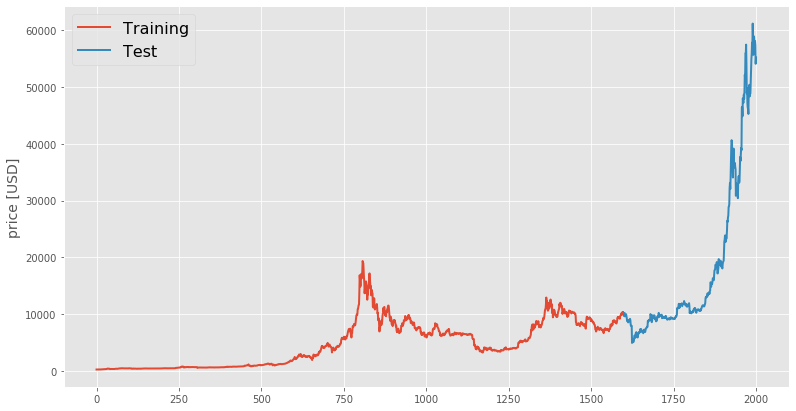

In [9]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

 #### Step 4: Data normalization 

In [10]:
scaler = MinMaxScaler()

In [11]:
train_norm = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test_norm = pd.DataFrame(scaler.transform(test), columns=test.columns)
# inverse_tranform

#### Step 5: Sliding window 

In [12]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

In [13]:
window_len = 20
X_train = extract_window_data(train_norm, window_len)
X_test = extract_window_data(test_norm, window_len)

In [14]:
y_train = train_norm[target_col][window_len:].values
y_test = test_norm[target_col][window_len:].values

### 5. Building LSTM

#### Step 1: Initialize LSTM 

In [15]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Step 2: Initialize params 

In [16]:
np.random.seed(42)
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

#### Step 3: Run LSTM 

In [17]:
X_train.shape

(1581, 20, 1)

In [18]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [19]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0051
Epoch 2/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 3/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 4/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 5/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 6/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 8/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 9/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 10/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 11/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 12/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 13/20
50/50 [===================

In [23]:
X_test.shape

(380, 20, 1)

In [22]:
X_test[:1]

array([[[0.52048796],
        [0.49012653],
        [0.49045988],
        [0.49512057],
        [0.493739  ],
        [0.50974892],
        [0.4933596 ],
        [0.4751465 ],
        [0.44779363],
        [0.44925893],
        [0.44391008],
        [0.43481269],
        [0.43501835],
        [0.45440002],
        [0.44633776],
        [0.44676165],
        [0.46251566],
        [0.46699371],
        [0.45356166],
        [0.4092862 ]]])

In [20]:
y_pred = model.predict(X_test).squeeze()
mean_absolute_error(y_pred, y_test)

0.07796521983023931

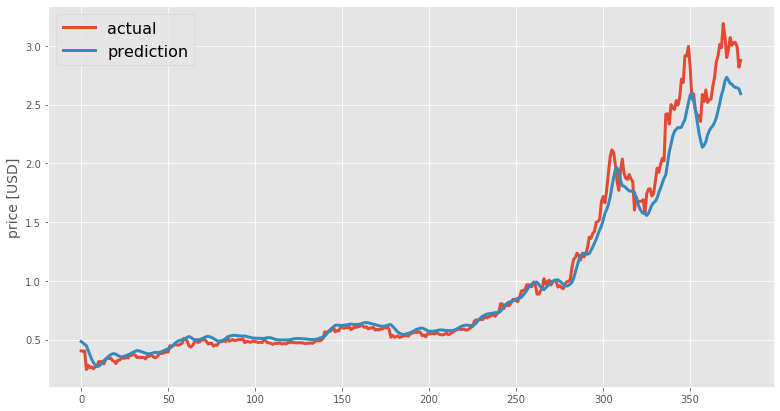

In [21]:
line_plot(y_test, y_pred, 'actual', 'prediction', lw=3)

### 6. Tune LSTM

### 7. Recursive Multi-step Forecast 

In [24]:
def push(x, y):
    push_len = len(y)
    assert len(x) >= push_len
    x[:-push_len] = x[push_len:]
    x[-push_len:] = y
    return x

In [25]:
# Example
# push(x, [5])

Stages:  
1. Read num_days to predict
1. Read data from db equal to window_size
1. Preprocess data from db
1. Run model on that data
1. Insert 1st predition to data and drop the first observation
1. Insert 1st prediction to prediction array
1. Run model on new data
1. Insert 2nd prediction to data and drop the first observation
1. Insert 2nd prediction to prediction array
1. .
1. .
1. .
1. reverse_transform on prediction array
1. return prediction array values OR/AND prediction plot

In [41]:
conn_params_dic = {
    "host"      : "localhost",
    "user"      : "postgres",
    "password"  : "1103"
}

def read_data_from_db(conn_params_dic, n_rows=5, db_name='crypto_info', order_col='time'):
    conn = connect(conn_params_dic)
    conn.autocommit = True

    cursor = conn.cursor()
    try:
        sql = 'SELECT * FROM ' + db_name + ' ORDER BY ' + order_col + ' DESC LIMIT ' + str(n_rows) + ';'
        df = pd.read_sql_query(sql, conn)        
    except:
        print("Unable to SELECT")

    cursor.close()
    conn.close()
    
    return df

In [36]:
def db_data_transformer(scaler, data):
    transformed_data = scaler.transform(data)
    return transformed_data

In [37]:
def df_data_inv_transformer(scaler, transformed_data):
    data = scaler.inverse_transformer(transformed_data)
    return data

In [35]:
def lstm_stock_predictions(num_days, data, model):
    y_pred_arr = []
    for day in range(num_days):
        y_pred = model.predict(data)
        y_pred_arr.append(y_pred)
        push(data, y_pred)
        
    return y_pred_arr

In [38]:
def y_pred_line_plot(line1, label1=None, title='Predicted stock prices', lw=2, save=False, save_path='\static', file_name = 'test.png'):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
    if save:
        full_path = os.path.join(save_path, file_name)
        fig.savefig(full_path)